# import all libraries we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Load and preprocess CIFAR-10 dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# visualize 10 samples from each class

<ipython-input-3-e75d7e055060>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


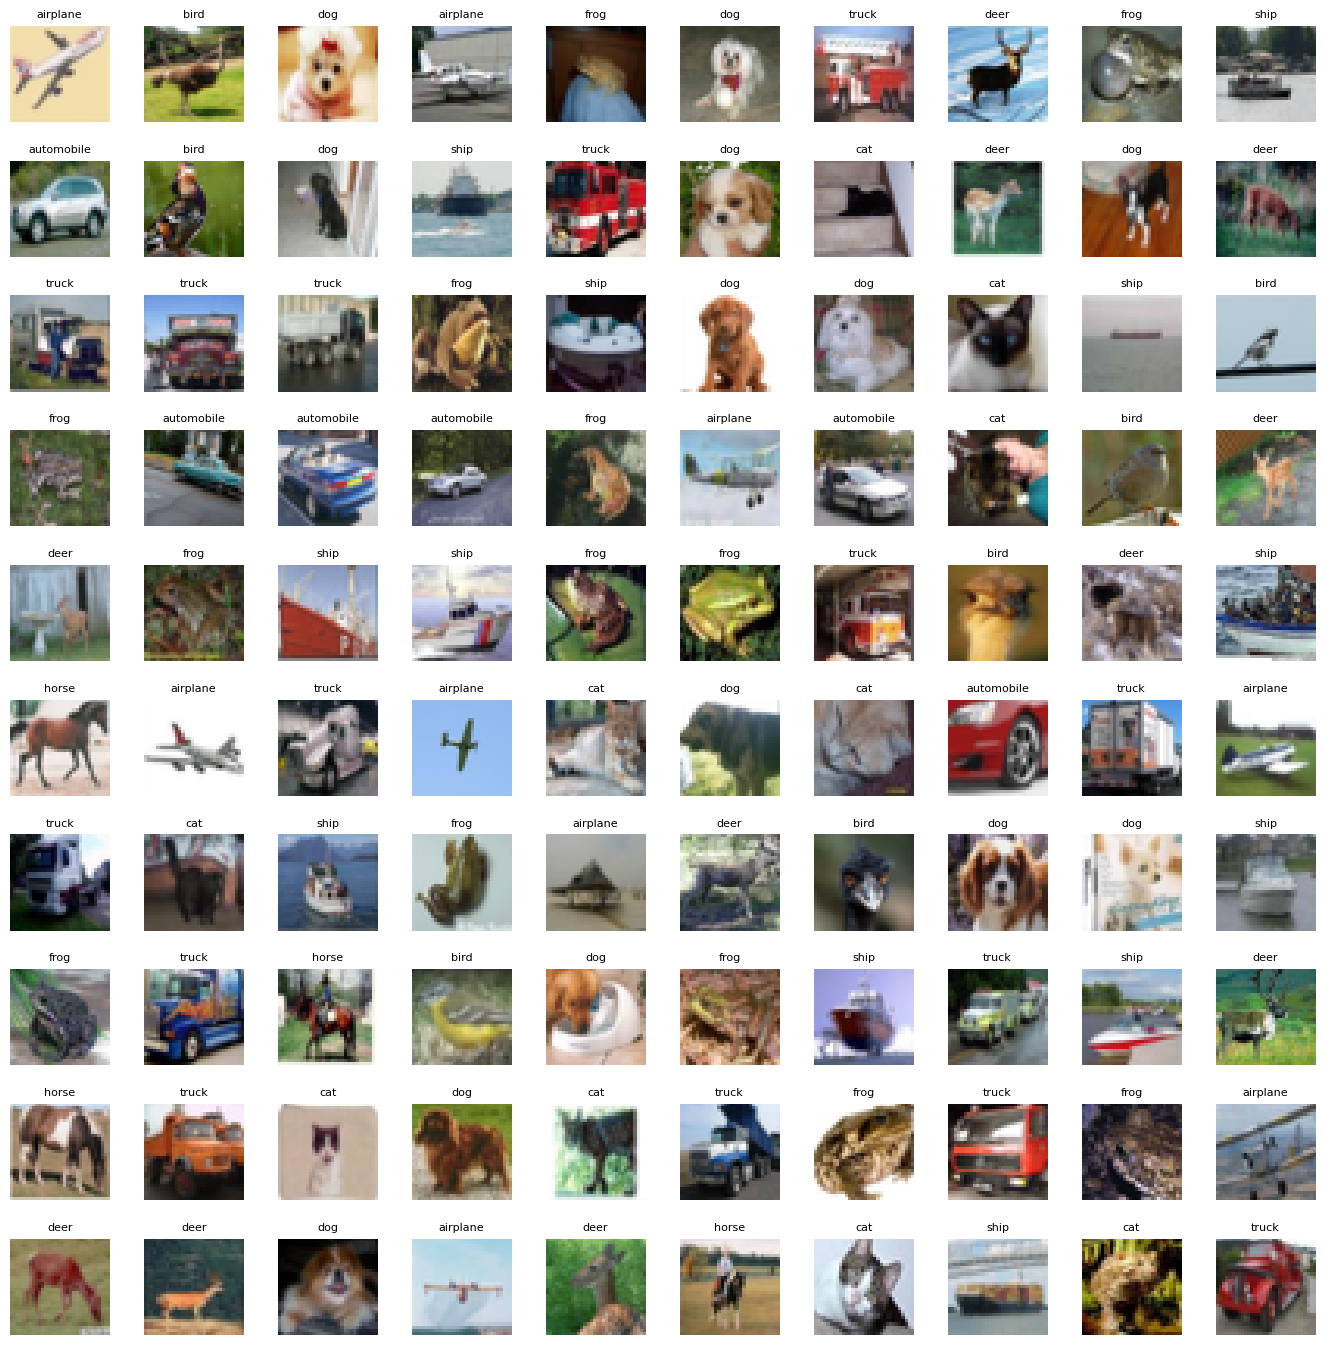

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()
n_train = len(x_train)


for i in np.arange(0, W_grid * L_grid):


    index = np.random.randint(0, n_train)
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

# normlaize the data and  Convert labels to categorical format

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0


num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


# Data Augmentation

In [ ]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

# the Baseline model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Baseline model

In [ ]:
# Compile the model with metrics
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the Baseline model

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3324 - loss: 1.8901 - val_accuracy: 0.5488 - val_loss: 1.3349
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5488 - loss: 1.3414 - val_accuracy: 0.5835 - val_loss: 1.2451
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6016 - loss: 1.2041 - val_accuracy: 0.6471 - val_loss: 1.0958
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6358 - loss: 1.1145 - val_accuracy: 0.6645 - val_loss: 1.0443
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6613 - loss: 1.0542 - val_accuracy: 0.6678 - val_loss: 1.0347
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6749 - loss: 1.0075 - val_accuracy: 0.6905 - val_loss: 0.9772
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6943 - loss: 0.9673 - val_accuracy: 0.7172 - val_loss: 0.9136
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7062 - loss: 0.9325 - val_accuracy: 0

# Plot accuracy and Plot loss

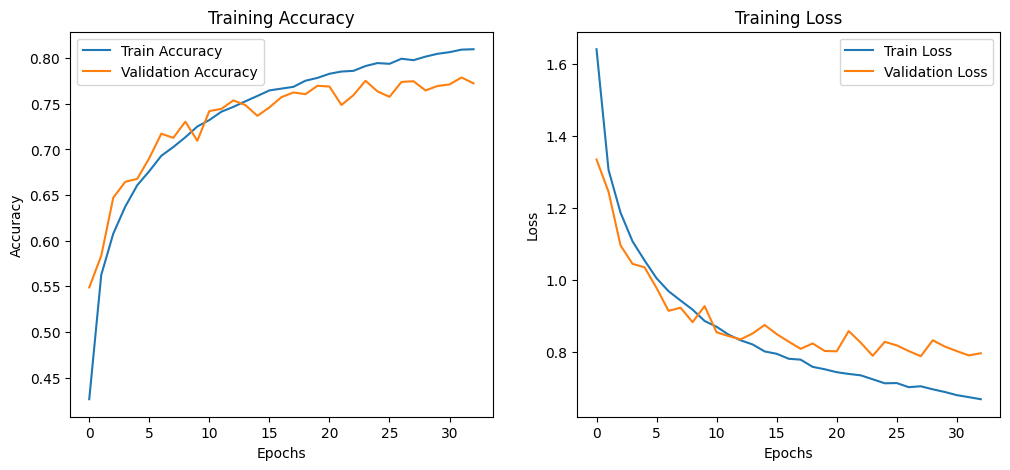

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.show()

# compute the test accuracy

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 1s - 2ms/step - accuracy: 0.7747 - loss: 0.7871

Test accuracy: 0.7747


# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(x_train)

# CNN model with skip connections

In [ ]:
num_classes = 10

model = models.Sequential([
    # Layer 1 - Conv Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Layer 2 - Conv Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Layer 3 - Conv Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    # Layer 4 - Global Average Pooling & Fully Connected Layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 324,394 (1.24 MB)

 Trainable params: 323,498 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

# Compile the model

In [ ]:

model.compile(optimizer="adamw",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#skip connections function

In [ ]:


def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    return x

# Training the Model

In [ ]:

history = model.fit(x_train, y_train, epochs=50, batch_size=64,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.3865 - loss: 1.8572 - val_accuracy: 0.4455 - val_loss: 1.8674
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6214 - loss: 1.1608 - val_accuracy: 0.5628 - val_loss: 1.4094
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6819 - loss: 0.9587 - val_accuracy: 0.6853 - val_loss: 0.9451
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7265 - loss: 0.8252 - val_accuracy: 0.7462 - val_loss: 0.7656
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7550 - loss: 0.7391 - val_accuracy: 0.7087 - val_loss: 0.8824
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7847 - loss: 0.6682 - val_accuracy: 0.7673 - val_loss: 0.6825
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7942 - loss: 0.6306 - val_accuracy: 0.7657 - val_loss: 0.7080
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8093 - loss: 0.5962 - val_accuracy: 

# Plot accuracy and Plot loss

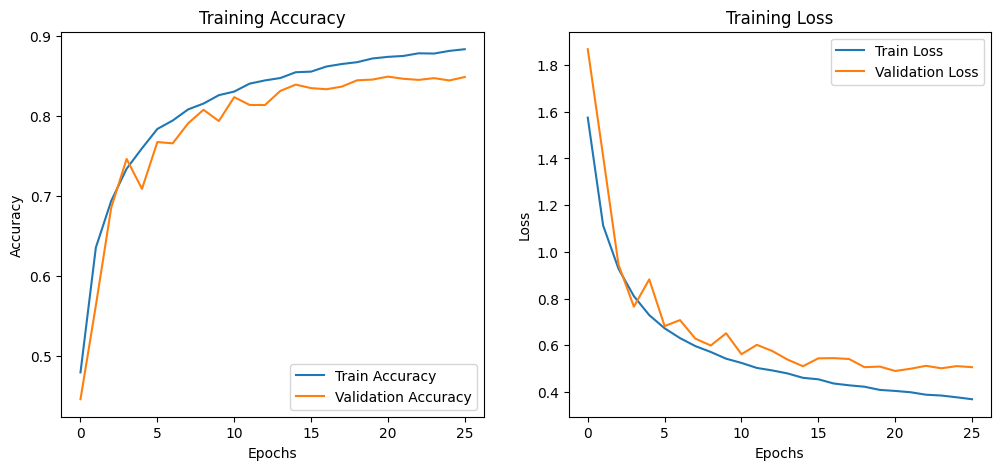

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.show()

# Evaluating the Model on the Test Data

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 1s - 3ms/step - accuracy: 0.8493 - loss: 0.4903

Test accuracy: 0.8493


# skip connection function

In [ ]:
def conv_block(x, filters):
    shortcut = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# advanced CNN skip connection model

In [ ]:
num_classes = 10  # CIFAR-10 has 10 classes
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(0.001))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = conv_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

x = conv_block(x, 128)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

x = conv_block(x, 256)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

# Global Average Pooling & Fully Connected Layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile the model

In [ ]:
optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the Model

In [ ]:
batch_size = 64
epochs = 150
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
model.fit(train_generator, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])


Epoch 1/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 47ms/step - accuracy: 0.3083 - loss: 2.7140 - val_accuracy: 0.4604 - val_loss: 1.7447 - learning_rate: 0.0010
Epoch 2/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.4969 - loss: 1.6851 - val_accuracy: 0.4621 - val_loss: 1.7429 - learning_rate: 0.0010
Epoch 3/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5518 - loss: 1.5104 - val_accuracy: 0.5676 - val_loss: 1.4442 - learning_rate: 0.0010
Epoch 4/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5797 - loss: 1.4336 - val_accuracy: 0.4653 - val_loss: 1.7640 - learning_rate: 0.0010
Epoch 5/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.6089 - loss: 1.3823 - val_accuracy: 0.5096 - val_loss: 1.7242 - learning_rate: 0.0010
Epoch 6/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.6286 - loss: 1.3305 - val_accuracy: 0.5022 - val_loss: 1.7809 - learning_rate: 0.0010
Epoch 7/150
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.6

# Plot accuracy and Plot loss

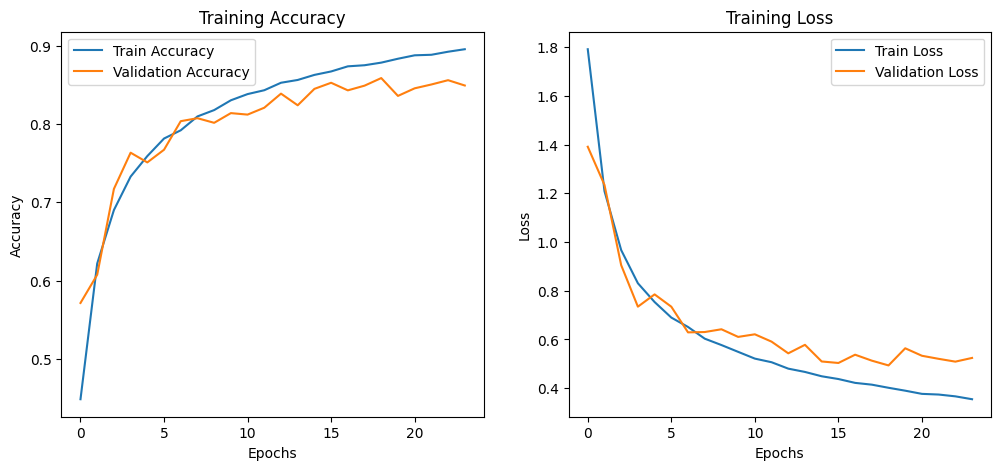

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.show()

# Evaluating the Model on the Test Data

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 3s - 8ms/step - accuracy: 0.8969 - loss: 0.4466

Test accuracy: 0.8969


# clear session

In [ ]:
from keras.backend import clear_session
clear_session()

# Load CIFAR-10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images to range [0, 1]

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to one-hot encoding

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# EfficientNetV2B0 requires 224x224 images so we resize the image

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

#  Data Augmentation & Resizing

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),  # Resize to EfficientNetV2 expected input size
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Create Dataset Pipelines

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(50000)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Load Pre-trained EfficientNetV2B0 Model

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet" ) # Use ImageNet pre-trained weights

#  Unfreeze More Layers for Better Fine-Tuning

In [ ]:

for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

#  Add Custom Classification Head

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

#  Compile Model with a Lower Learning Rate for Fine-Tuning

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Reduce LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#  Train the Model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=18
)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 232s 93ms/step - accuracy: 0.2334 - loss: 2.1054 - val_accuracy: 0.5508 - val_loss: 1.3520
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.5821 - loss: 1.2073 - val_accuracy: 0.8075 - val_loss: 0.6061
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.7546 - loss: 0.7338 - val_accuracy: 0.8571 - val_loss: 0.4430
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.8145 - loss: 0.5591 - val_accuracy: 0.9051 - val_loss: 0.2941
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.8543 - loss: 0.4438 - val_accuracy: 0.9212 - val_loss: 0.2353
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.8697 - loss: 0.3899 - val_accuracy: 0.9224 - val_loss: 0.2321
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 95s 61ms/step - accuracy: 0.8831 - loss: 0.3452 - val_accuracy: 0.9333 - val_loss: 0.2009
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 61ms/step - accuracy: 0.9009 

# Evaluate the model on the test dataset

In [ ]:
# Load the saved model
model = tf.keras.models.load_model("efficientnetv2b0_cifar10_fixed.h5")


test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the test accuracy
print(f"🔥 Test Accuracy: {test_accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9546 - loss: 0.1408
🔥 Test Accuracy: 95.24%


# function to evaluate_efficientnetv2b0

In [5]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

def evaluate_efficientnetv2b0(model, x_test, y_test):
    X_test_resized = tf.image.resize(x_test, (224, 224))
    y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim == 2 else y_test

    y_pred_prob = model.predict(X_test_resized)
    y_pred_labels = np.argmax(y_pred_prob, axis=1)

    cm = confusion_matrix(y_test_labels, y_pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - EfficientNetV2-B0")
    plt.show()

    report = classification_report(y_test_labels, y_pred_labels, target_names=labels, output_dict=True)

    classes = labels
    recall = [report[cls]["recall"] for cls in classes]
    precision = [report[cls]["precision"] for cls in classes]
    f1_score = [report[cls]["f1-score"] for cls in classes]

    plt.figure(figsize=(10, 5))
    x = np.arange(len(classes))
    plt.bar(x - 0.2, recall, width=0.2, label="Recall", color="blue")
    plt.bar(x, precision, width=0.2, label="Precision", color="green")
    plt.bar(x + 0.2, f1_score, width=0.2, label="F1-score", color="red")
    plt.xticks(x, classes, rotation=45)
    plt.xlabel("Classes")
    plt.ylabel("Score")
    plt.title("Recall, Precision, and F1-score - EfficientNetV2-B0")
    plt.legend()
    plt.show()

    return report["accuracy"]

# Models Performance  Evaluation and Comparison


Evaluating Model: /content/baseline_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


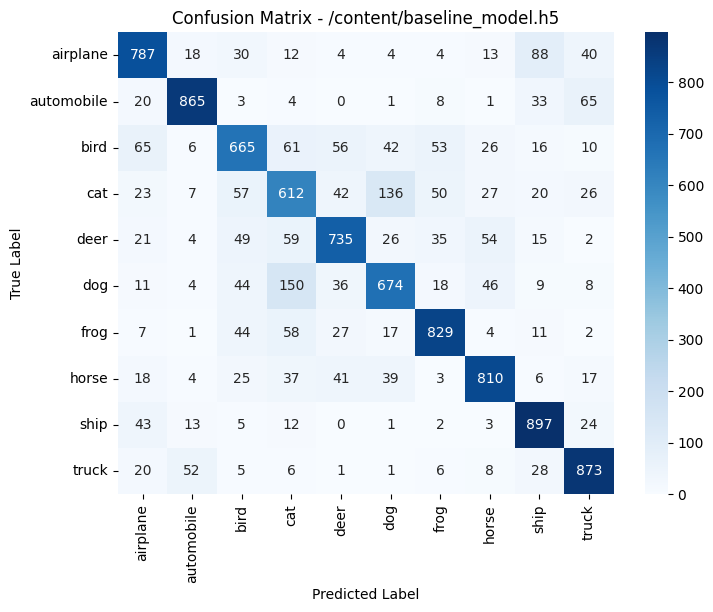

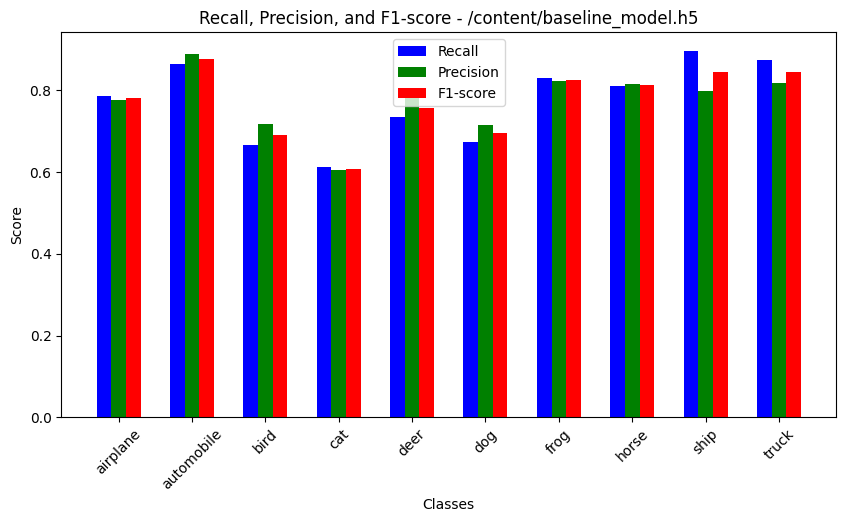


Evaluating Model: /content/efficientnetv2b0_cifar10_fixed.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step


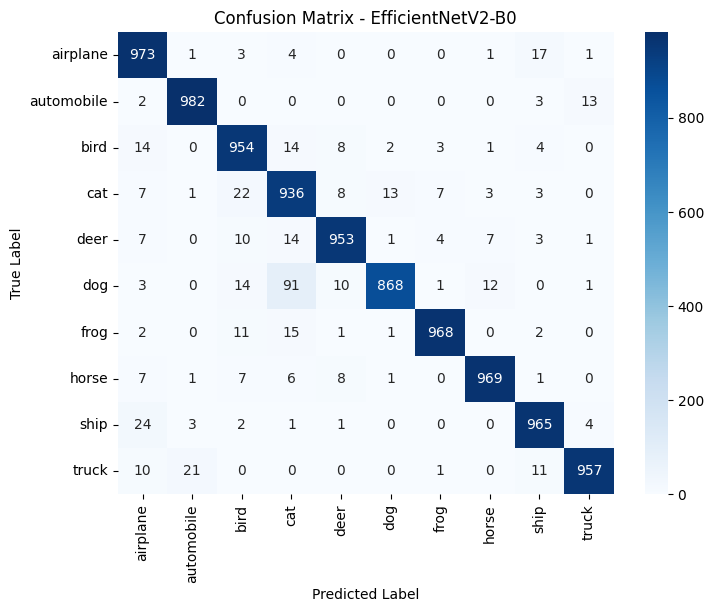

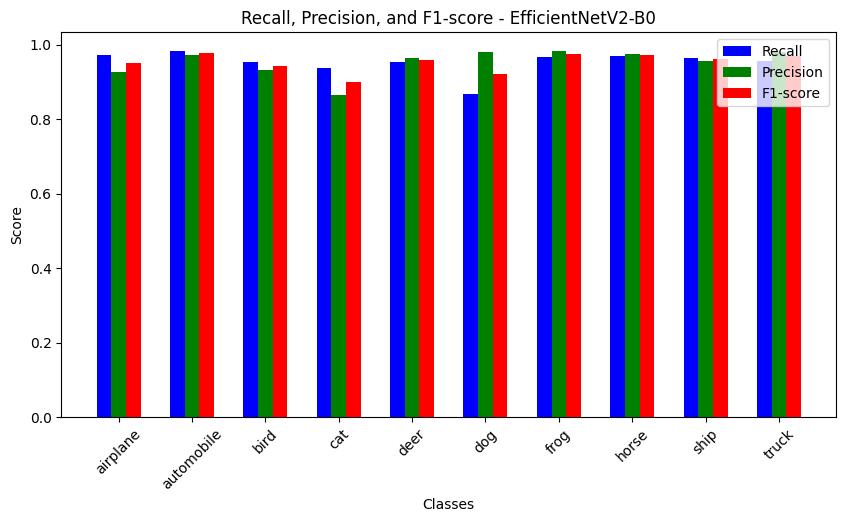


Evaluating Model: /content/skipconnection 89_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step


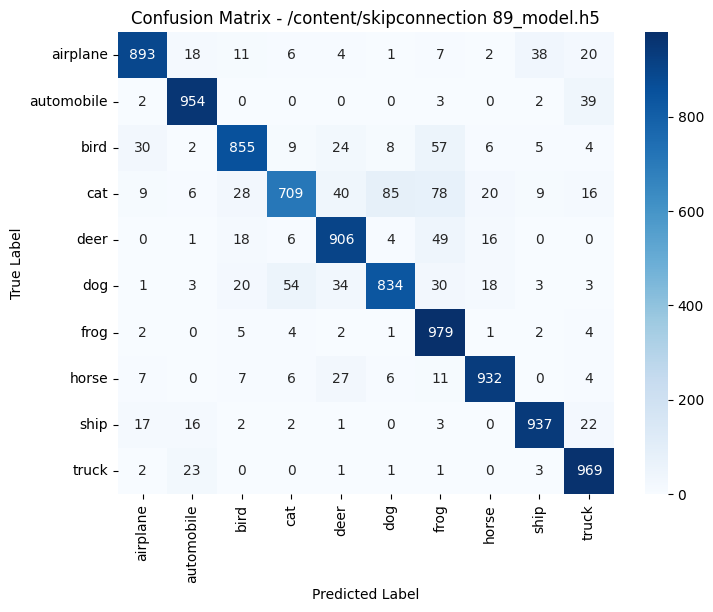

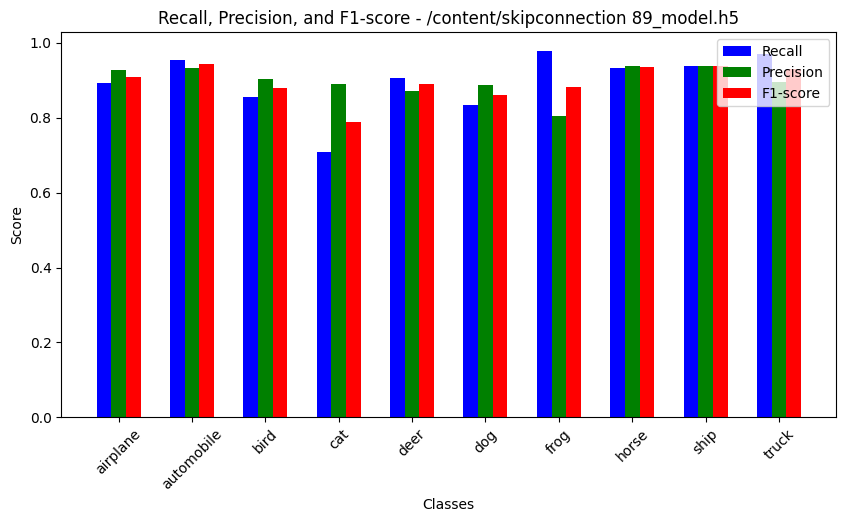


Evaluating Model: /content/skipconnection_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 74ms/step


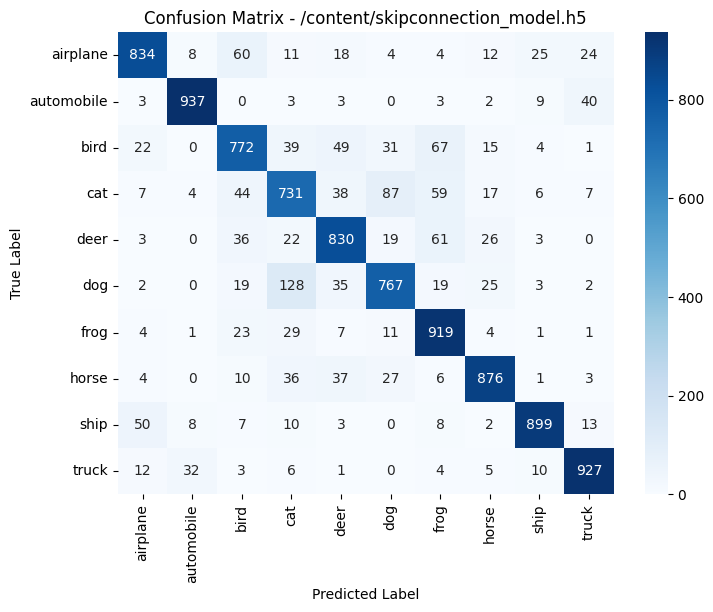

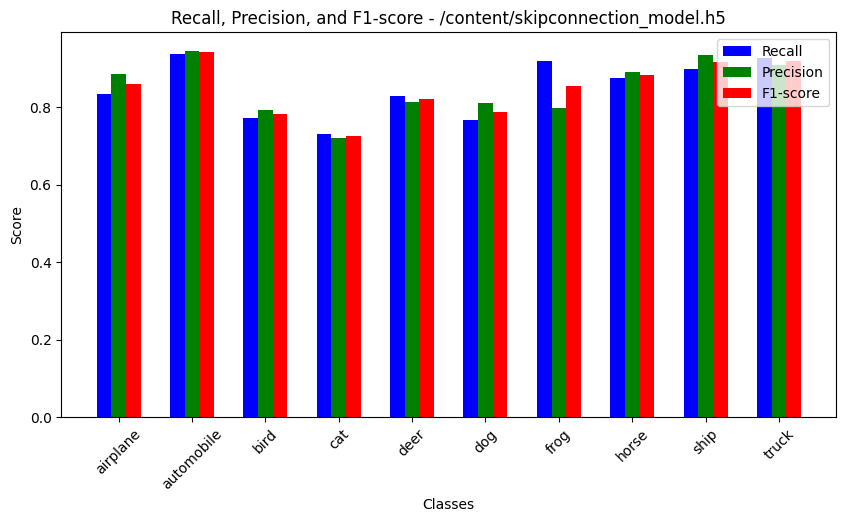

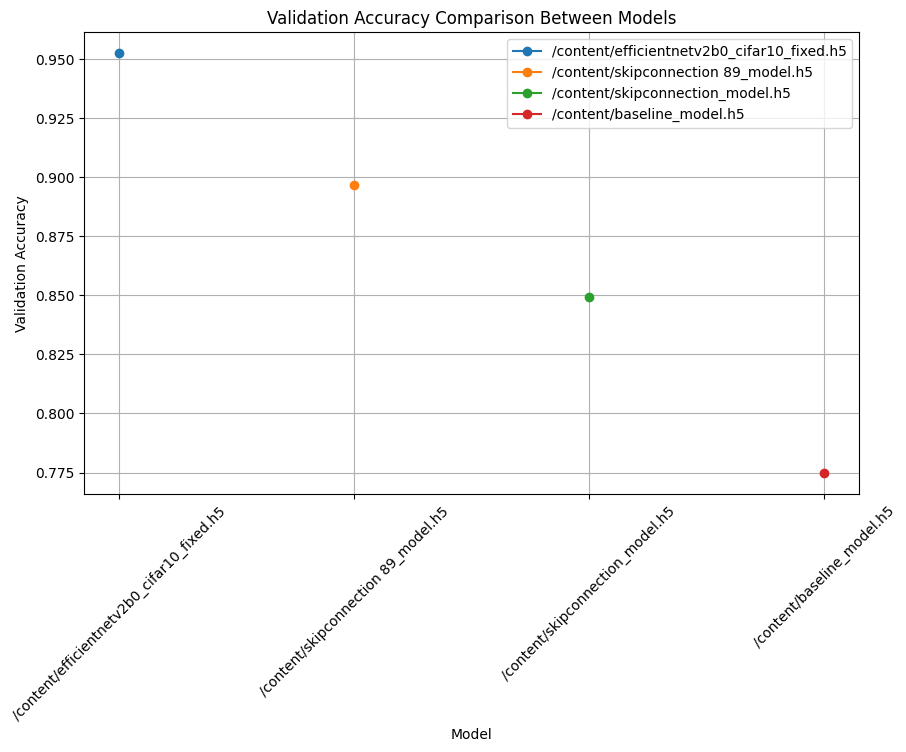

Best Model: /content/efficientnetv2b0_cifar10_fixed.h5 (Green)


In [6]:
model_files = ["/content/baseline_model.h5", "/content/efficientnetv2b0_cifar10_fixed.h5", "/content/skipconnection 89_model.h5", "/content/skipconnection_model.h5"]
model_histories = {}
model_accuracies = {}

y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim == 2 else y_test

for model_file in model_files:
    print(f"\nEvaluating Model: {model_file}")

    model = tf.keras.models.load_model(model_file)

    if "efficientnetv2b0" in model_file.lower():
        model_accuracies[model_file] = evaluate_efficientnetv2b0(model, x_test, y_test)
    else:
        y_pred_prob = model.predict(x_test)
        y_pred_labels = np.argmax(y_pred_prob, axis=1)

        cm = confusion_matrix(y_test_labels, y_pred_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {model_file}")
        plt.show()

        report = classification_report(y_test_labels, y_pred_labels, target_names=labels, output_dict=True)

        classes = labels
        recall = [report[cls]["recall"] for cls in classes]
        precision = [report[cls]["precision"] for cls in classes]
        f1_score = [report[cls]["f1-score"] for cls in classes]

        plt.figure(figsize=(10, 5))
        x = np.arange(len(classes))
        plt.bar(x - 0.2, recall, width=0.2, label="Recall", color="blue")
        plt.bar(x, precision, width=0.2, label="Precision", color="green")
        plt.bar(x + 0.2, f1_score, width=0.2, label="F1-score", color="red")
        plt.xticks(x, classes, rotation=45)
        plt.xlabel("Classes")
        plt.ylabel("Score")
        plt.title(f"Recall, Precision, and F1-score - {model_file}")
        plt.legend()
        plt.show()

        model_accuracies[model_file] = report["accuracy"]

plt.figure(figsize=(10, 6))

sorted_models = sorted(model_accuracies.keys(), key=lambda x: model_accuracies[x], reverse=True)

for idx, model_file in enumerate(sorted_models):
    plt.plot(idx, model_accuracies[model_file], marker='o', linestyle='-', label=model_file)

plt.xticks(range(len(sorted_models)), sorted_models, rotation=45)
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison Between Models")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Model: {sorted_models[0]} (Green)")
